# Project 4 Part II

In [286]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from datetime import datetime
from matplotlib import pyplot as plt
from matplotlib import dates as md
from pylab import rcParams
rcParams['figure.figsize'] = 15, 8

In [281]:
import pandas as pd
url = 'https://raw.githubusercontent.com/numenta/NAB/master/data/realTweets/Twitter_volume_AMZN.csv'
df = pd.read_csv(url)

In [282]:
df.head()

,timestamp,value
0,2015-02-26 21:42:53,57
1,2015-02-26 21:47:53,43
2,2015-02-26 21:52:53,55
3,2015-02-26 21:57:53,64
4,2015-02-26 22:02:53,93


In [283]:
def plot_dates_values(df, title, x, y):
    dates = df["timestamp"].to_list()
    values = df["value"].to_list()
    dates = [datetime.strptime(x, "%Y-%m-%d %H:%M:%S") for x in dates]
    plt.subplots_adjust(bottom=0.2)
    plt.xticks(rotation=25)
    ax = plt.gca()
    xfmt = md.DateFormatter("%Y-%m-%d %H:%M:%S")
    ax.xaxis.set_major_formatter(xfmt)
    plt.plot(dates, values)
    plt.title(title)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.show()

#### A plot of our original AMZN Twitter Volume dataset

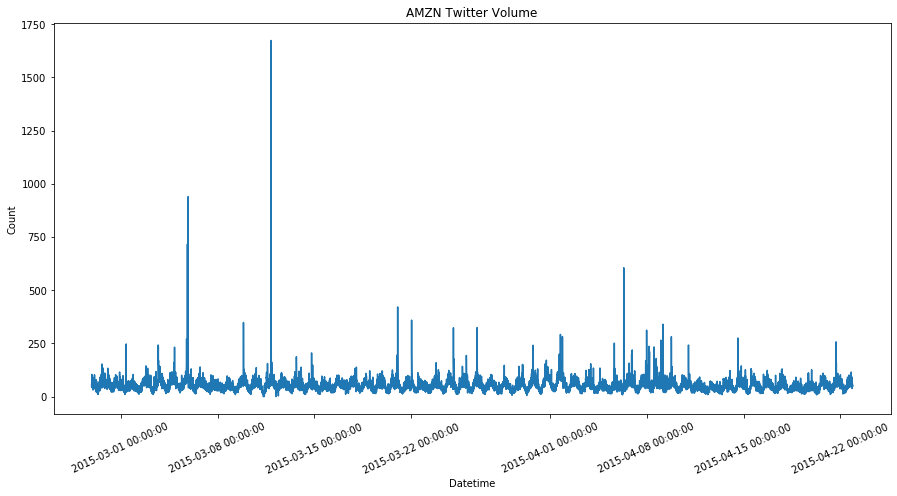

In [287]:
plot_dates_values(df, 'AMZN Twitter Volume', 'Datetime', 'Count')

#### A plot of the portion of dataset we will use to train with, this portion seemingly has no anomalies and it between the dates 4-15-2015 and 4-21-2015

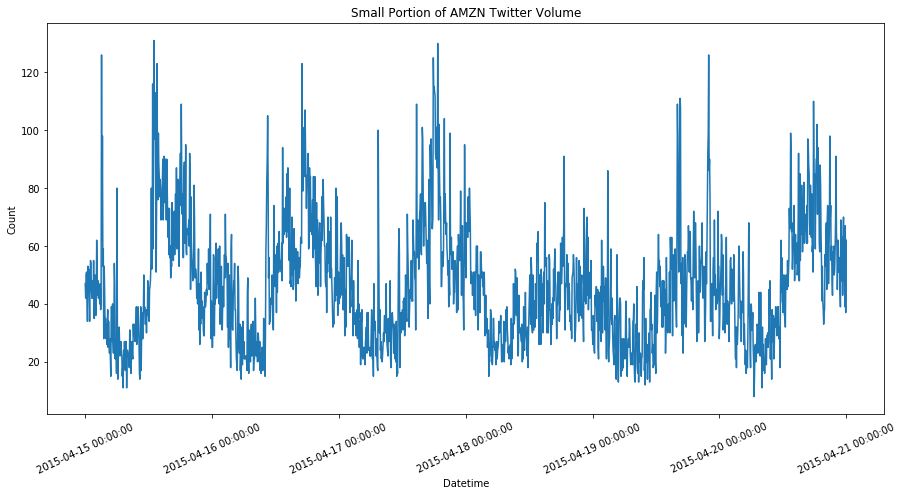

In [288]:
data = df
data['date'] = data['timestamp']
data['date'] = pd.to_datetime(data.date)
data = data.sort_values(by=['date'])
data = data[(data['date'] >= '2015-04-15 00:00:00') & (data['date'] < '2015-04-21 00:00:00')]
data = data[['timestamp', 'value']]
plot_dates_values(data, 'Small Portion of AMZN Twitter Volume', 'Datetime', 'Count')

#### Steps are calculated from 5 minute intervals

In [289]:
steps = 24*60/5
steps = int(steps)
num_data = steps*6
print('Time steps: ',steps)
print('Expected Data Points: ',num_data)

Time steps:  288
Expected Data Points:  1728


In [290]:
values = data.value.to_list()
mean = np.mean(values)
values -= mean
std = np.std(values)
values /= std
print('Mean: ', mean)
print('Standard Deviation: ', std)
print('Number of Data Points: ', len(values))

Mean:  46.336226851851855
Standard Deviation:  20.445892520223673
Number of Data Points:  1728


In [291]:
output = []
for i in range(len(values) - steps):
    output.append(values[i : (i + steps)])
trainX = np.expand_dims(output, axis=2)
print("Training input shape: ", trainX.shape)

Training input shape:  (1440, 288, 1)


#### Function to create model for autoencoder using early stopping by monitoring validation loss

In [292]:
def fit_model(model):
    history = model.fit(
        trainX,
        trainX,
        epochs=100,
        batch_size=128,
        validation_split=0.1,
        verbose = 1,
        callbacks=[
            keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
        ],
    )
    return history

#### Function to plot loss against validation loss, plot predicted trainX against actual trainX, and calcuate threshold from loss between predicted and expected trainX

In [293]:
def plot_loss_acc(history, model, m, v):
    plt.plot(history.history["loss"], label="Training Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.title('Model ' + str(m) +  ': Version '+ str(v))
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    trainXpred = model.predict(trainX)
    train_mae_loss = np.mean(np.abs(trainXpred - trainX), axis=1)

    plt.hist(train_mae_loss, bins=50)
    plt.title('Train MAE loss')
    plt.xlabel("Train MAE loss")
    plt.ylabel("No of samples")
    plt.show()

    threshold = np.max(train_mae_loss)
    print("Reconstruction error threshold: ", threshold)
    return threshold, trainXpred, train_mae_loss

#### Function to plot small portion of data to show how well model has recreated trainX

In [294]:
def plot_train_pred(trainX, trainXpred):
    plt.plot(trainX[0])
    plt.title('Original trainX data')
    plt.show()
    plt.plot(trainXpred[0])
    plt.title('Predicted trainX data')
    plt.show()

#### Function to plot test data after being normalized

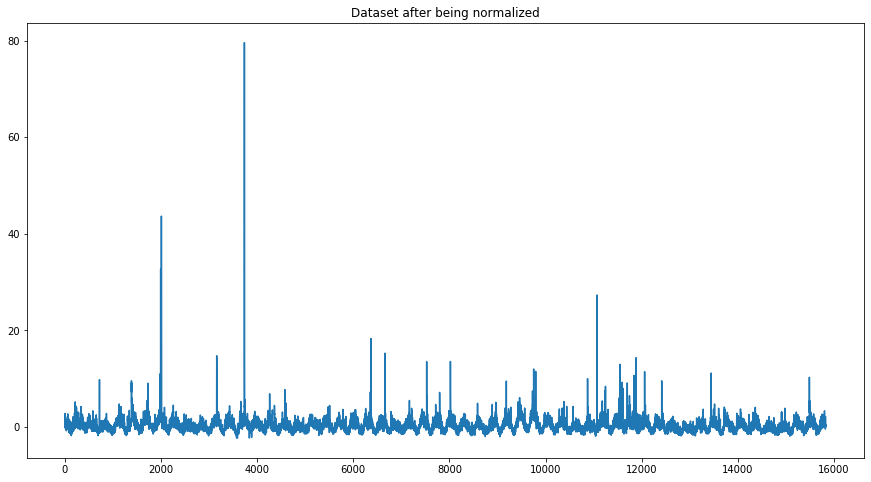

Test input shape:  (15543, 288, 1)


In [295]:
def plot_test(df):
    testVal = df.value.to_list()
    testVal -= mean
    testVal /= std
    plt.plot(testVal.tolist())
    plt.title('Dataset after being normalized')
    plt.show()

    output = []
    for i in range(len(testVal) - steps):
        output.append(testVal[i : (i + steps)])
    testX = np.expand_dims(output, axis=2)
    print("Test input shape: ", testX.shape)
    return testX
testX = plot_test(df)

#### Function to test MAE loss plot, calculate which data points are over the threshold and plot these anomalies on top of the original data

In [296]:
def testpred(model, testX, threshold):
    testXpred = model.predict(testX)
    test_mae_loss = np.mean(np.abs(testXpred - testX), axis=1)
    test_mae_loss = test_mae_loss.reshape((-1))

    plt.hist(test_mae_loss, bins=50)
    plt.title("Test MAE Loss")
    plt.xlabel("Test MAE Loss")
    plt.ylabel("No of Samples")
    plt.show()

    anomalies = (test_mae_loss > threshold).tolist()
    print("Number of anomaly samples: ", np.sum(anomalies))
    print("Indices of anomaly samples: ", np.where(anomalies))
    
    anomalous_data_indices = []
    for data_idx in range(steps - 1, len(testVal) - steps + 1):
        time_series = range(data_idx - steps + 1, data_idx)
        if all([anomalies[j] for j in time_series]):
            anomalous_data_indices.append(data_idx)
            
    df_subset = df.iloc[anomalous_data_indices, :]
    plt.subplots_adjust(bottom=0.2)
    plt.xticks(rotation=25)
    ax = plt.gca()
    xfmt = md.DateFormatter("%Y-%m-%d %H:%M:%S")
    ax.xaxis.set_major_formatter(xfmt)

    dates = df["timestamp"].to_list()
    dates = [datetime.strptime(x, "%Y-%m-%d %H:%M:%S") for x in dates]
    values = df["value"].to_list()
    plt.plot(dates, values, label="test data")

    dates = df_subset["timestamp"].to_list()
    dates = [datetime.strptime(x, "%Y-%m-%d %H:%M:%S") for x in dates]
    values = df_subset["value"].to_list()
    plt.plot(dates, values, label="anomalies", color="r")

    plt.legend()
    plt.show()

# Model 1

#### Model 1 is a convolutional reconstruction autoencoder model
#### For model 1, I will show process of hypterparamter tuning
#### This model initially has one encoder and decoder containing an input layer, 5 1D convolutional/transpose layers, with 2 dropouts
#### Threshold varies for every model and version because it is calculated using trainX and predicted trainX

In [297]:
model = keras.Sequential(
    [   
        ##ENCODER
        layers.Input(shape=(trainX.shape[1], trainX.shape[2])),
        layers.Conv1D(
            filters=64, kernel_size=8, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16, kernel_size=8, padding="same", strides=2, activation="relu"
        ),
        
        ### DECODER
        layers.Conv1DTranspose(
            filters=16, kernel_size=8, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=64, kernel_size=8, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=8, padding="same")
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_63 (Conv1D)           (None, 144, 64)           576       
_________________________________________________________________
dropout_84 (Dropout)         (None, 144, 64)           0         
_________________________________________________________________
conv1d_64 (Conv1D)           (None, 72, 16)            8208      
_________________________________________________________________
conv1d_transpose_103 (Conv1D (None, 144, 16)           2064      
_________________________________________________________________
dropout_85 (Dropout)         (None, 144, 16)           0         
_________________________________________________________________
conv1d_transpose_104 (Conv1D (None, 288, 64)           8256      
_________________________________________________________________
conv1d_transpose_105 (Conv1D (None, 288, 1)          

In [269]:
history = fit_model(model)

Epoch 1/100
11/11 [==============================] - 3s 259ms/step - loss: 0.7670 - val_loss: 0.4227
Epoch 2/100
11/11 [==============================] - 2s 223ms/step - loss: 0.3890 - val_loss: 0.3652
Epoch 3/100
11/11 [==============================] - 2s 182ms/step - loss: 0.3319 - val_loss: 0.3021
Epoch 4/100
11/11 [==============================] - 2s 177ms/step - loss: 0.2839 - val_loss: 0.2484
Epoch 5/100
11/11 [==============================] - 2s 191ms/step - loss: 0.2541 - val_loss: 0.2032
Epoch 6/100
11/11 [==============================] - 2s 197ms/step - loss: 0.2183 - val_loss: 0.1528
Epoch 7/100
11/11 [==============================] - 2s 177ms/step - loss: 0.1844 - val_loss: 0.1185
Epoch 8/100
11/11 [==============================] - 2s 178ms/step - loss: 0.1558 - val_loss: 0.0950
Epoch 9/100
11/11 [==============================] - 2s 187ms/step - loss: 0.1352 - val_loss: 0.0789
Epoch 10/100
11/11 [==============================] - 2s 203ms/step - loss: 0.1173 - val_lo

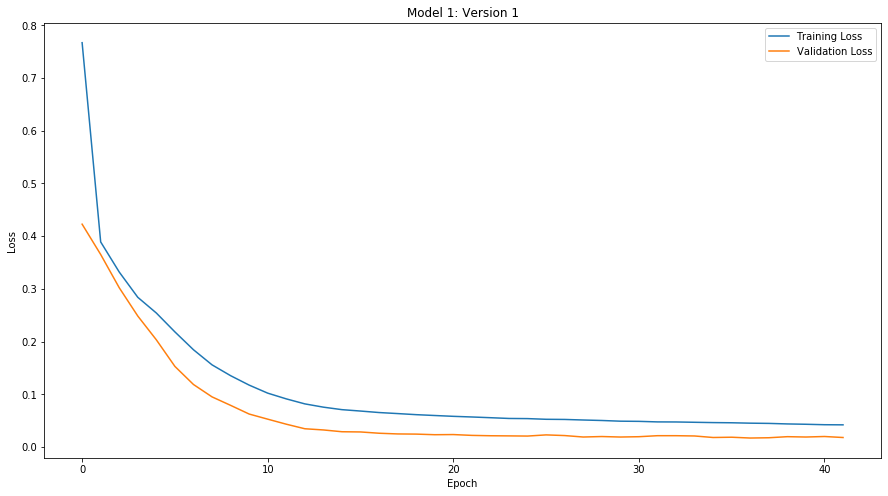

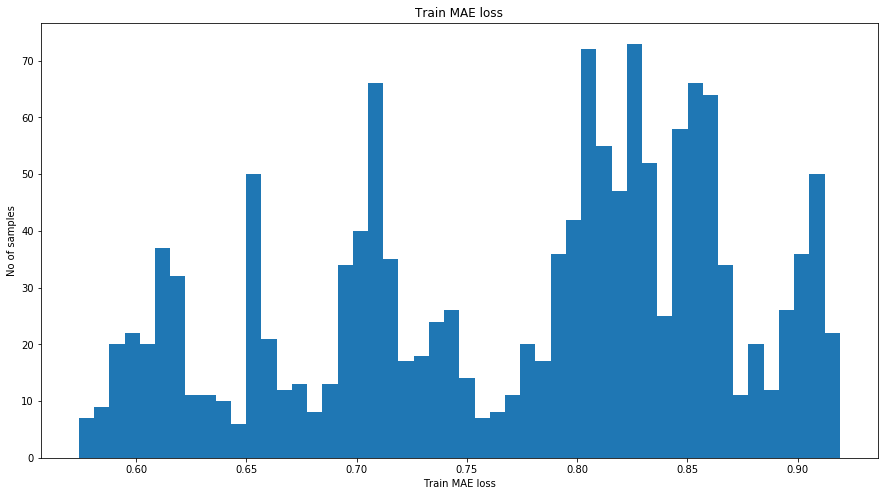

Reconstruction error threshold:  0.9190723855664115


In [298]:
threshold, trainXpred, train_mae_loss = plot_loss_acc(history, model, 1, 1)

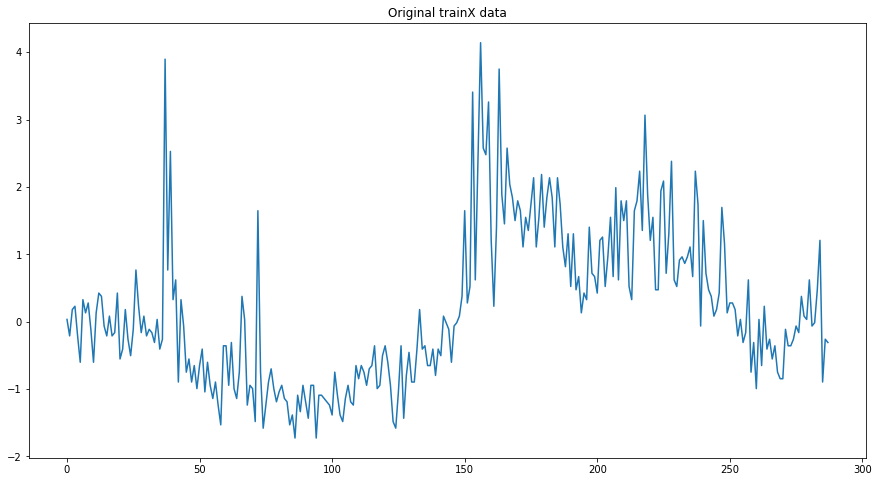

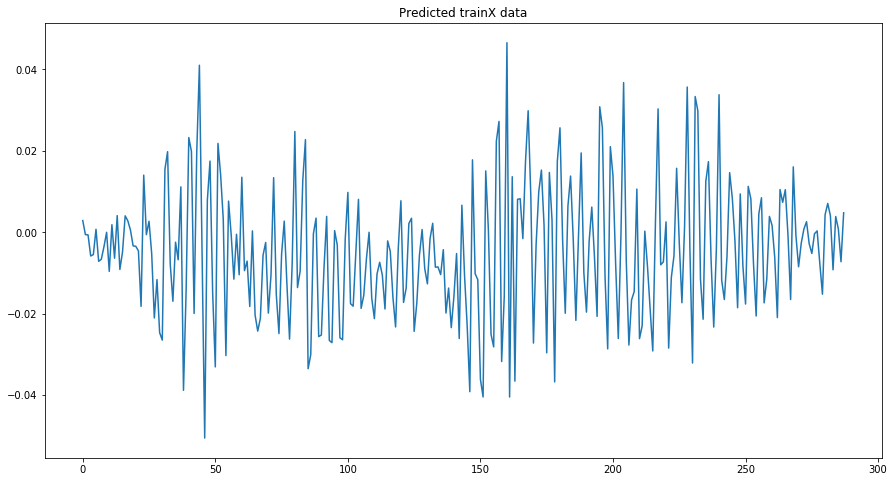

In [299]:
plot_train_pred(trainX, trainXpred)

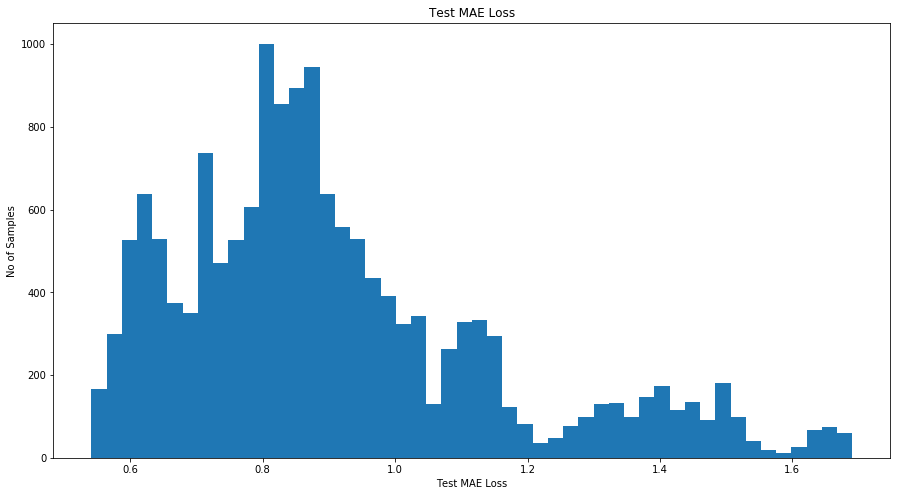

Number of anomaly samples:  5706
Indices of anomaly samples:  (array([   78,    79,    80, ..., 15491, 15492, 15493], dtype=int64),)


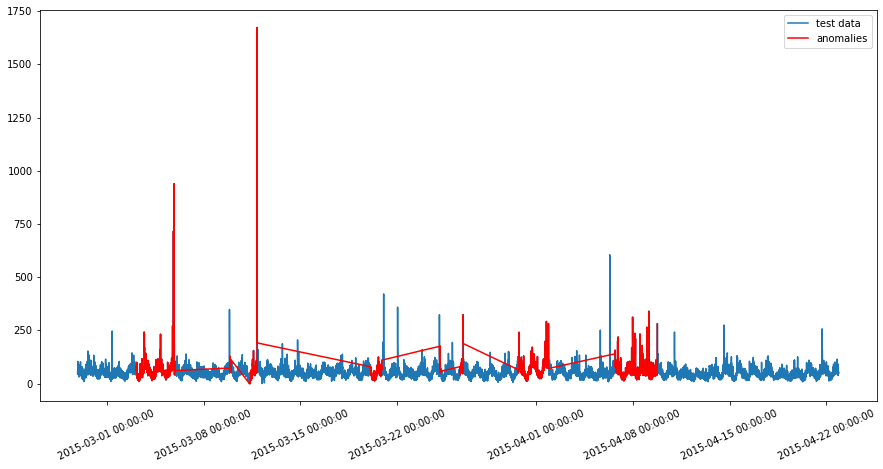

In [300]:
testpred(model, testX, threshold)

#### Change activation function from relu to linear, and kernel size from 8 to 4

In [301]:
model = keras.Sequential(
    [   
        ##ENCODER
        layers.Input(shape=(trainX.shape[1], trainX.shape[2])),
        layers.Conv1D(
            filters=64, kernel_size=4, padding="same", strides=2, activation="linear"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16, kernel_size=4, padding="same", strides=2, activation="linear"
        ),
        
        ### DECODER
        layers.Conv1DTranspose(
            filters=16, kernel_size=4, padding="same", strides=2, activation="linear"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=64, kernel_size=4, padding="same", strides=2, activation="linear"
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same")
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_65 (Conv1D)           (None, 144, 64)           320       
_________________________________________________________________
dropout_86 (Dropout)         (None, 144, 64)           0         
_________________________________________________________________
conv1d_66 (Conv1D)           (None, 72, 16)            4112      
_________________________________________________________________
conv1d_transpose_106 (Conv1D (None, 144, 16)           1040      
_________________________________________________________________
dropout_87 (Dropout)         (None, 144, 16)           0         
_________________________________________________________________
conv1d_transpose_107 (Conv1D (None, 288, 64)           4160      
_________________________________________________________________
conv1d_transpose_108 (Conv1D (None, 288, 1)          

In [302]:
history = fit_model(model)

Epoch 1/100
11/11 [==============================] - 1s 107ms/step - loss: 0.5490 - val_loss: 0.3007
Epoch 2/100
11/11 [==============================] - 1s 85ms/step - loss: 0.2575 - val_loss: 0.1851
Epoch 3/100
11/11 [==============================] - 1s 87ms/step - loss: 0.1689 - val_loss: 0.0898
Epoch 4/100
11/11 [==============================] - 1s 85ms/step - loss: 0.1135 - val_loss: 0.0476
Epoch 5/100
11/11 [==============================] - 1s 98ms/step - loss: 0.0813 - val_loss: 0.0212
Epoch 6/100
11/11 [==============================] - 1s 126ms/step - loss: 0.0641 - val_loss: 0.0151
Epoch 7/100
11/11 [==============================] - 1s 98ms/step - loss: 0.0574 - val_loss: 0.0122
Epoch 8/100
11/11 [==============================] - 1s 84ms/step - loss: 0.0527 - val_loss: 0.0105
Epoch 9/100
11/11 [==============================] - 1s 85ms/step - loss: 0.0495 - val_loss: 0.0096
Epoch 10/100
11/11 [==============================] - 1s 111ms/step - loss: 0.0472 - val_loss: 0.0

Epoch 82/100
11/11 [==============================] - 1s 87ms/step - loss: 0.0240 - val_loss: 0.0020
Epoch 83/100
11/11 [==============================] - 1s 92ms/step - loss: 0.0237 - val_loss: 0.0019
Epoch 84/100
11/11 [==============================] - 1s 84ms/step - loss: 0.0238 - val_loss: 0.0019A: 0s - loss: 0.


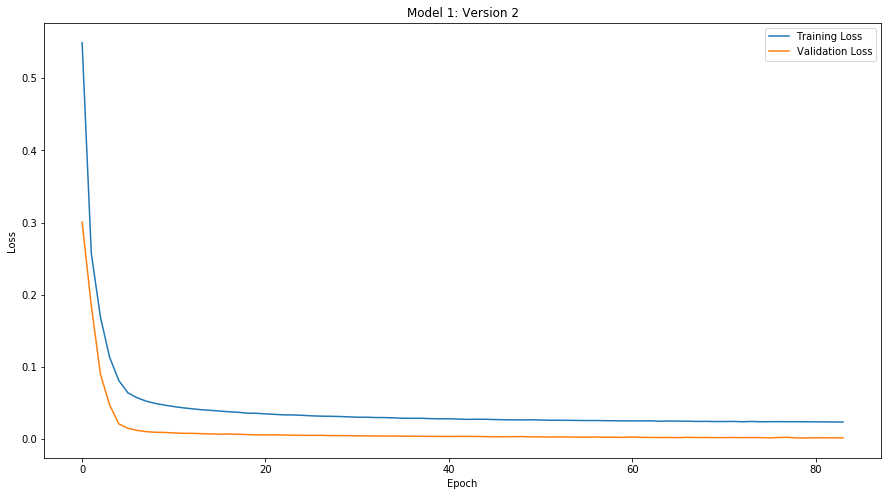

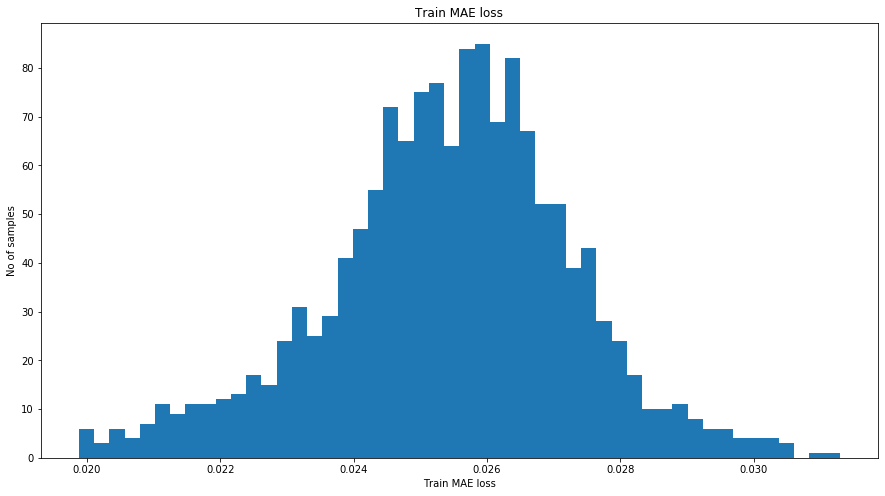

Reconstruction error threshold:  0.03129316380124178


In [303]:
threshold, trainXpred, train_mae_loss = plot_loss_acc(history, model, 1, 2)

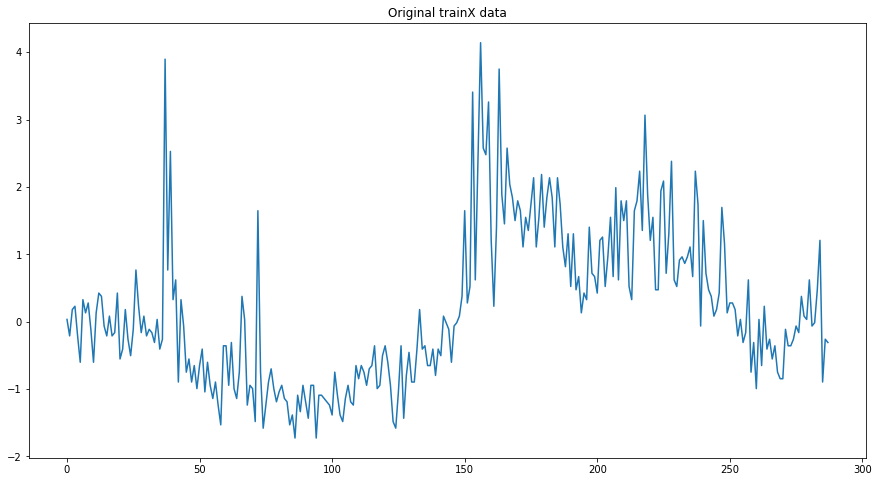

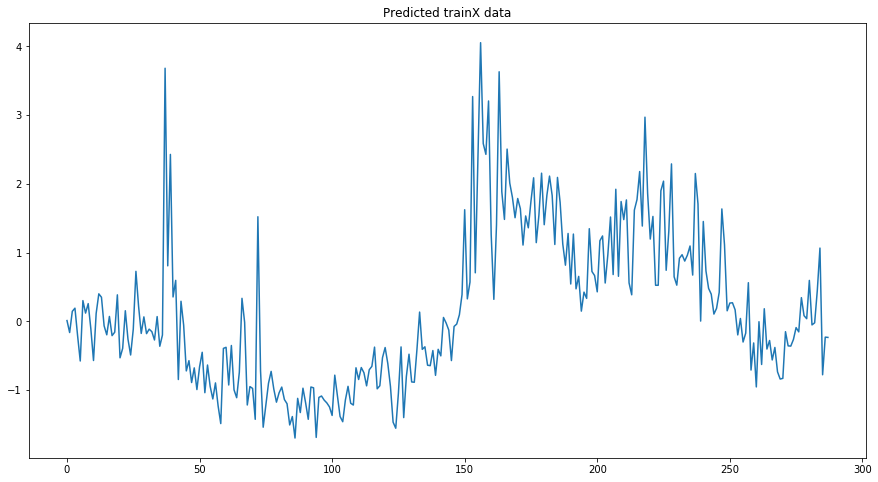

In [304]:
plot_train_pred(trainX, trainXpred)

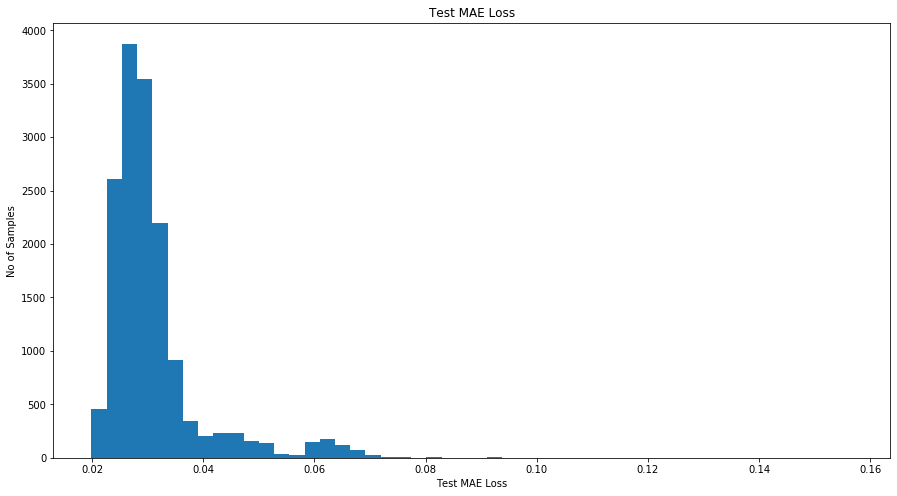

Number of anomaly samples:  4604
Indices of anomaly samples:  (array([    1,     2,     3, ..., 15497, 15516, 15522], dtype=int64),)


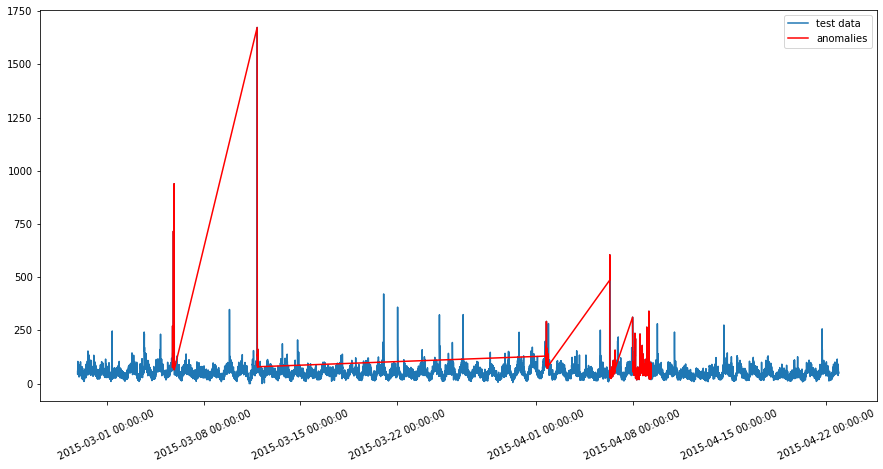

In [305]:
testpred(model, testX, threshold)

#### Change filter size from 64 to 32

In [153]:
model = keras.Sequential(
    [   
        ##ENCODER
        layers.Input(shape=(trainX.shape[1], trainX.shape[2])),
        layers.Conv1D(
            filters=32, kernel_size=4, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16, kernel_size=4, padding="same", strides=2, activation="relu"
        ),
        
        ### DECODER
        layers.Conv1DTranspose(
            filters=16, kernel_size=4, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32, kernel_size=4, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=4, padding="same")
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_38 (Conv1D)           (None, 144, 32)           160       
_________________________________________________________________
dropout_39 (Dropout)         (None, 144, 32)           0         
_________________________________________________________________
conv1d_39 (Conv1D)           (None, 72, 16)            2064      
_________________________________________________________________
conv1d_transpose_60 (Conv1DT (None, 144, 16)           1040      
_________________________________________________________________
dropout_40 (Dropout)         (None, 144, 16)           0         
_________________________________________________________________
conv1d_transpose_61 (Conv1DT (None, 288, 32)           2080      
_________________________________________________________________
conv1d_transpose_62 (Conv1DT (None, 288, 1)          

In [154]:
history = fit_model(model)

Epoch 1/100
11/11 [==============================] - 1s 129ms/step - loss: 0.9329 - val_loss: 0.7844
Epoch 2/100
11/11 [==============================] - 1s 78ms/step - loss: 0.7194 - val_loss: 0.5025
Epoch 3/100
11/11 [==============================] - 1s 77ms/step - loss: 0.4369 - val_loss: 0.3195
Epoch 4/100
11/11 [==============================] - 1s 85ms/step - loss: 0.3341 - val_loss: 0.2707
Epoch 5/100
11/11 [==============================] - 1s 82ms/step - loss: 0.2902 - val_loss: 0.2489
Epoch 6/100
11/11 [==============================] - 1s 76ms/step - loss: 0.2646 - val_loss: 0.2112
Epoch 7/100
11/11 [==============================] - ETA: 0s - loss: 0.239 - 1s 79ms/step - loss: 0.2393 - val_loss: 0.1776
Epoch 8/100
11/11 [==============================] - 1s 82ms/step - loss: 0.2142 - val_loss: 0.1445
Epoch 9/100
11/11 [==============================] - 1s 77ms/step - loss: 0.1899 - val_loss: 0.1173
Epoch 10/100
11/11 [==============================] - 1s 85ms/step - loss: 

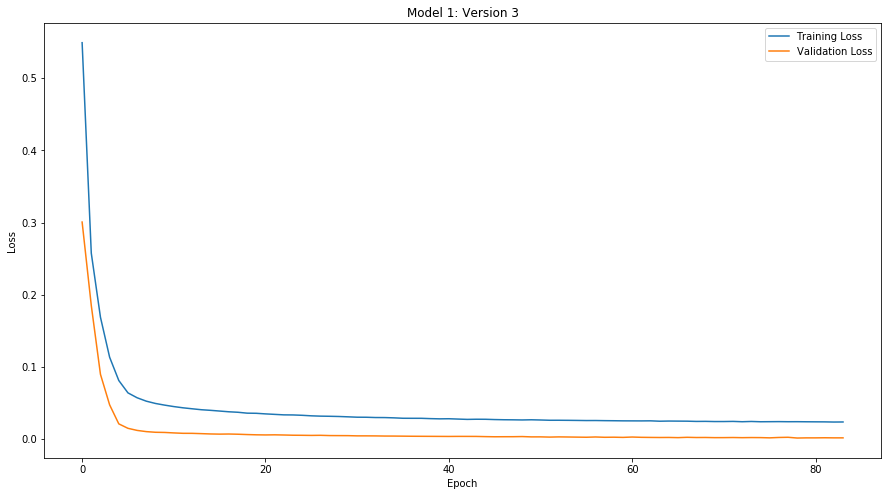

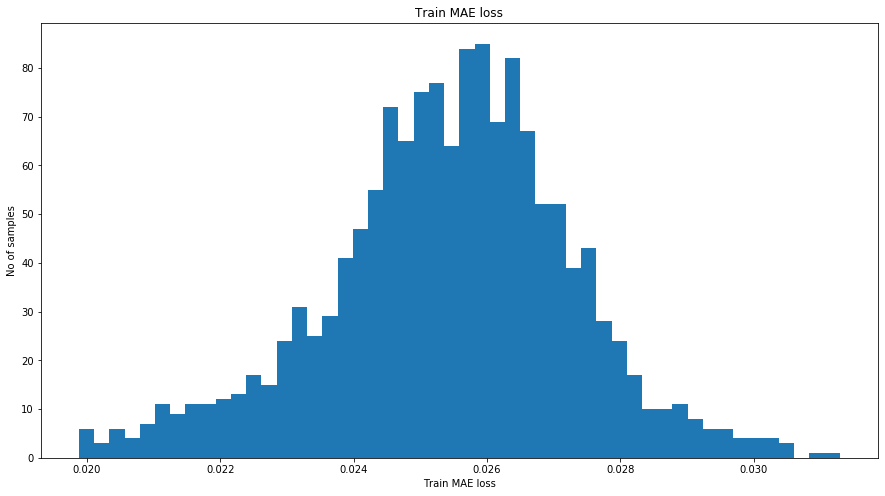

Reconstruction error threshold:  0.03129316380124178


In [308]:
threshold, trainXpred, train_mae_loss = plot_loss_acc(history, model, 1, 3)

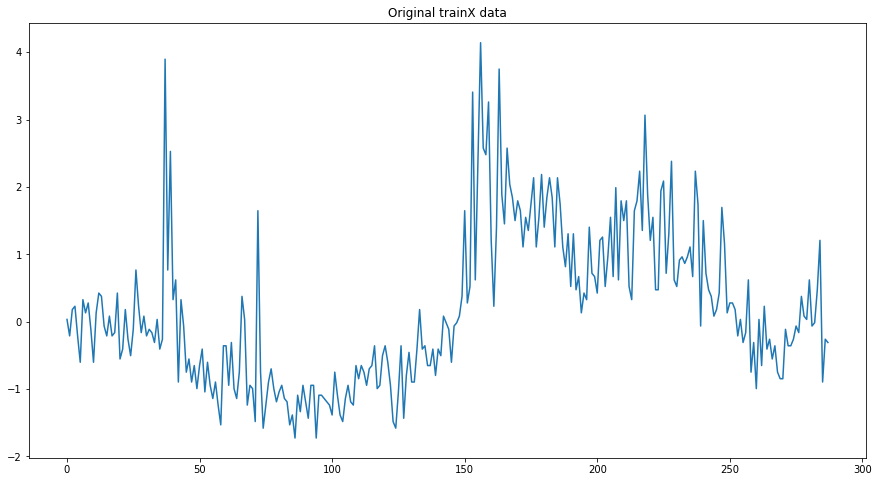

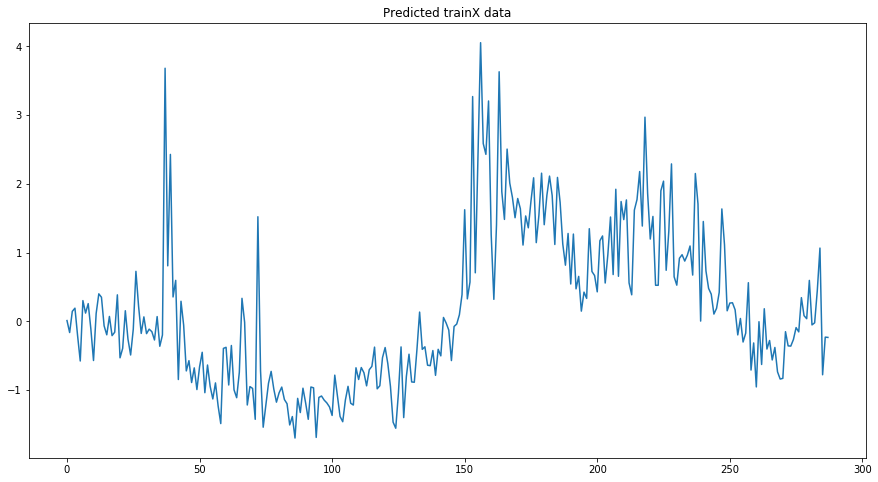

In [309]:
plot_train_pred(trainX, trainXpred)

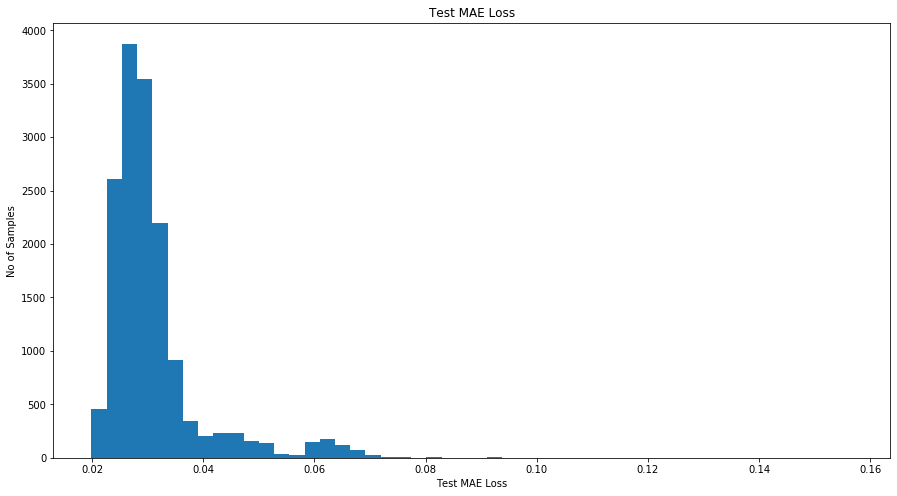

Number of anomaly samples:  4604
Indices of anomaly samples:  (array([    1,     2,     3, ..., 15497, 15516, 15522], dtype=int64),)


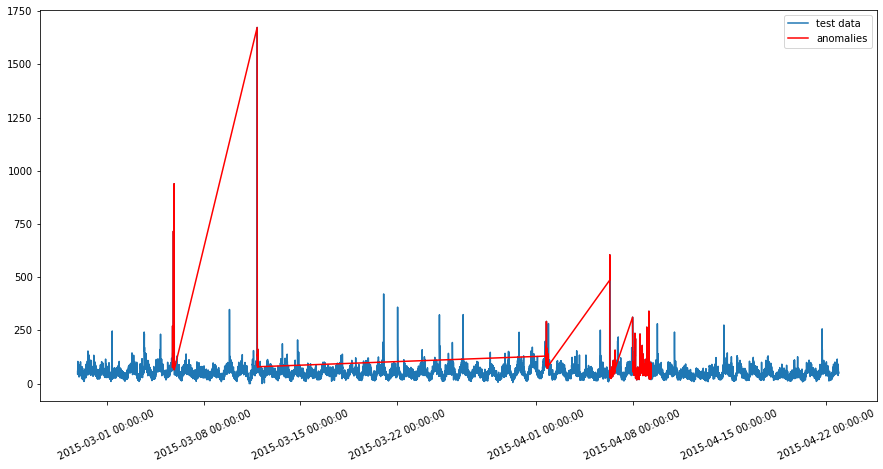

In [310]:
testpred(model, testX, threshold)

#### Changing all filters to 16

In [311]:
model = keras.Sequential(
    [   
        ##ENCODER
        layers.Input(shape=(trainX.shape[1], trainX.shape[2])),
        layers.Conv1D(
            filters=16, kernel_size=4, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16, kernel_size=4, padding="same", strides=2, activation="relu"
        ),
        
        ### DECODER
        layers.Conv1DTranspose(
            filters=16, kernel_size=4, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=16, kernel_size=4, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=4, padding="same")
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_67 (Conv1D)           (None, 144, 16)           80        
_________________________________________________________________
dropout_88 (Dropout)         (None, 144, 16)           0         
_________________________________________________________________
conv1d_68 (Conv1D)           (None, 72, 16)            1040      
_________________________________________________________________
conv1d_transpose_109 (Conv1D (None, 144, 16)           1040      
_________________________________________________________________
dropout_89 (Dropout)         (None, 144, 16)           0         
_________________________________________________________________
conv1d_transpose_110 (Conv1D (None, 288, 16)           1040      
_________________________________________________________________
conv1d_transpose_111 (Conv1D (None, 288, 1)          

In [312]:
history = fit_model(model)

Epoch 1/100
11/11 [==============================] - 1s 63ms/step - loss: 0.9463 - val_loss: 0.8522
Epoch 2/100
11/11 [==============================] - 0s 40ms/step - loss: 0.8426 - val_loss: 0.6971
Epoch 3/100
11/11 [==============================] - 0s 40ms/step - loss: 0.6505 - val_loss: 0.4996
Epoch 4/100
11/11 [==============================] - 0s 40ms/step - loss: 0.4478 - val_loss: 0.3304
Epoch 5/100
11/11 [==============================] - 0s 40ms/step - loss: 0.3434 - val_loss: 0.2790
Epoch 6/100
11/11 [==============================] - 0s 42ms/step - loss: 0.2999 - val_loss: 0.2600
Epoch 7/100
11/11 [==============================] - 0s 42ms/step - loss: 0.2769 - val_loss: 0.2284
Epoch 8/100
11/11 [==============================] - 0s 43ms/step - loss: 0.2578 - val_loss: 0.2051
Epoch 9/100
11/11 [==============================] - 0s 42ms/step - loss: 0.2410 - val_loss: 0.1785
Epoch 10/100
11/11 [==============================] - 0s 41ms/step - loss: 0.2252 - val_loss: 0.1567

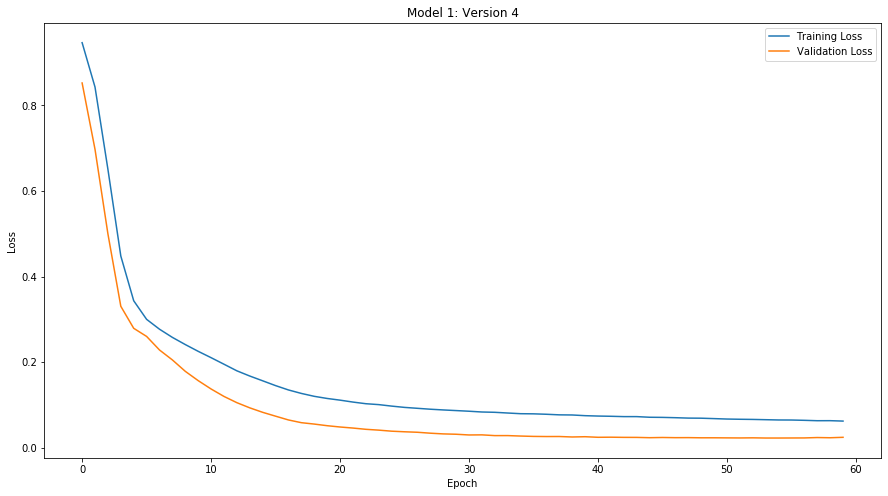

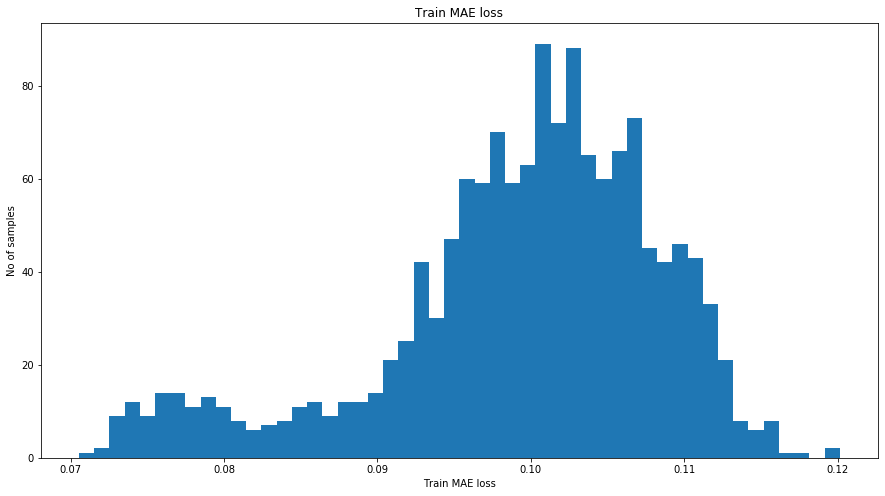

Reconstruction error threshold:  0.12012933530239701


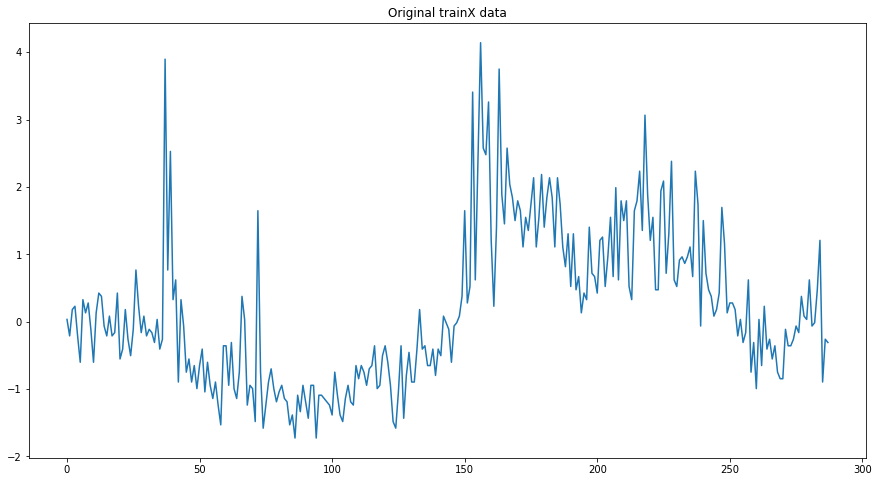

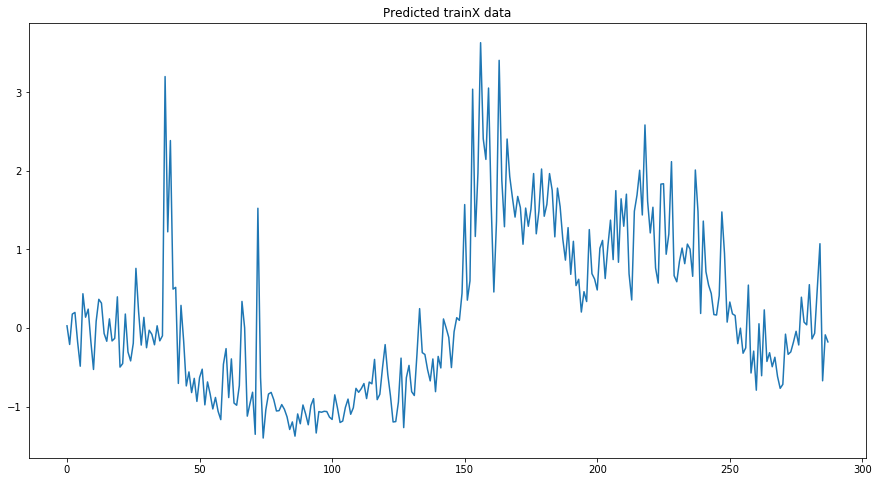

In [314]:
threshold, trainXpred, train_mae_loss = plot_loss_acc(history, model,1,4)
plot_train_pred(trainX, trainXpred)

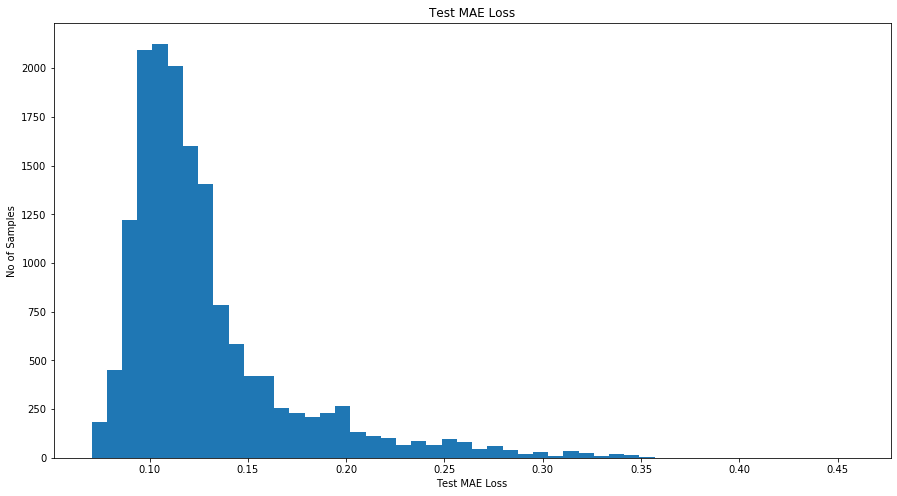

Number of anomaly samples:  6762
Indices of anomaly samples:  (array([    1,     2,     3, ..., 15498, 15518, 15522], dtype=int64),)


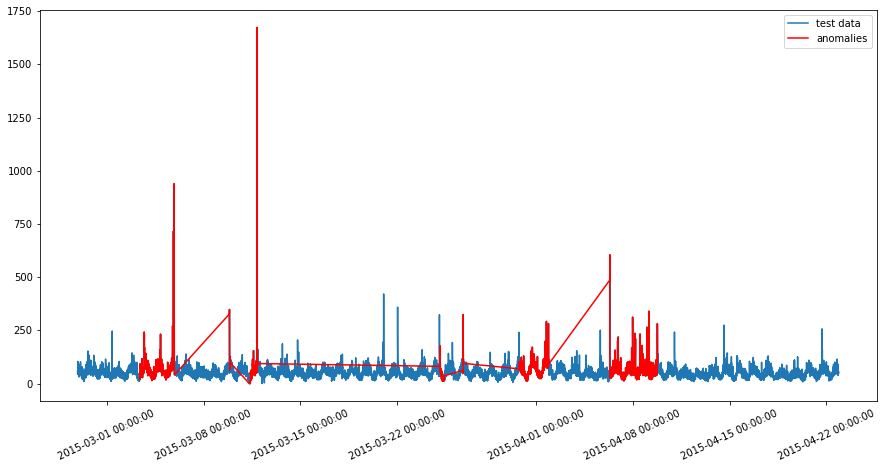

In [315]:
testpred(model, testX, threshold)

#### Changing the filter size of inner layers from 16 to 8

In [316]:
model = keras.Sequential(
    [   
        ##ENCODER
        layers.Input(shape=(trainX.shape[1], trainX.shape[2])),
        layers.Conv1D(
            filters=16, kernel_size=4, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=8, kernel_size=4, padding="same", strides=2, activation="relu"
        ),
        
        ### DECODER
        layers.Conv1DTranspose(
            filters=8, kernel_size=4, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=16, kernel_size=4, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=4, padding="same")
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_69 (Conv1D)           (None, 144, 16)           80        
_________________________________________________________________
dropout_90 (Dropout)         (None, 144, 16)           0         
_________________________________________________________________
conv1d_70 (Conv1D)           (None, 72, 8)             520       
_________________________________________________________________
conv1d_transpose_112 (Conv1D (None, 144, 8)            264       
_________________________________________________________________
dropout_91 (Dropout)         (None, 144, 8)            0         
_________________________________________________________________
conv1d_transpose_113 (Conv1D (None, 288, 16)           528       
_________________________________________________________________
conv1d_transpose_114 (Conv1D (None, 288, 1)          

In [324]:
history = fit_model(model)

Epoch 1/100
11/11 [==============================] - 13s 1s/step - loss: 0.9705 - val_loss: 0.9153
Epoch 2/100
11/11 [==============================] - 11s 1s/step - loss: 0.9668 - val_loss: 0.9169
Epoch 3/100
11/11 [==============================] - 14s 1s/step - loss: 0.9652 - val_loss: 0.9136
Epoch 4/100
11/11 [==============================] - 16s 1s/step - loss: 0.9637 - val_loss: 0.9134
Epoch 5/100
11/11 [==============================] - 14s 1s/step - loss: 0.9606 - val_loss: 0.9075
Epoch 6/100
11/11 [==============================] - 13s 1s/step - loss: 0.9573 - val_loss: 0.9087
Epoch 7/100
11/11 [==============================] - 16s 1s/step - loss: 0.9510 - val_loss: 0.9065
Epoch 8/100
11/11 [==============================] - 13s 1s/step - loss: 0.9464 - val_loss: 0.9111
Epoch 9/100
11/11 [==============================] - 14s 1s/step - loss: 0.9499 - val_loss: 0.9139
Epoch 10/100
11/11 [==============================] - 12s 1s/step - loss: 0.9454 - val_loss: 0.9070
Epoch 11/

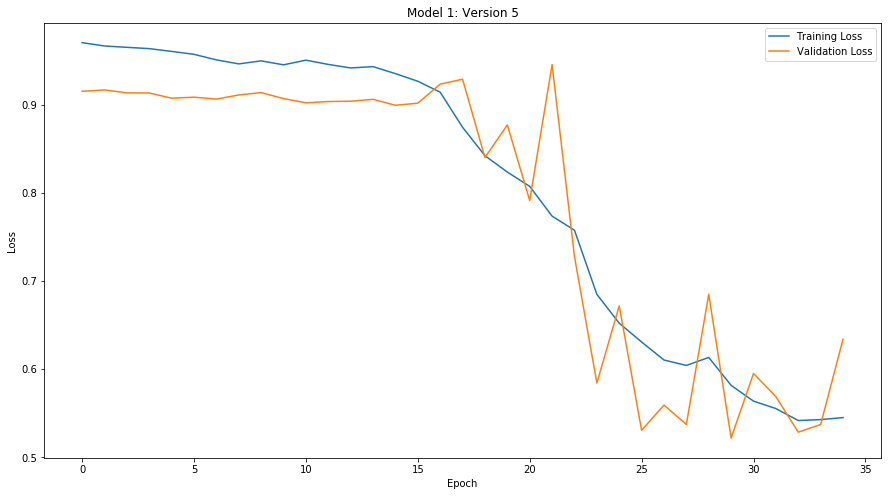

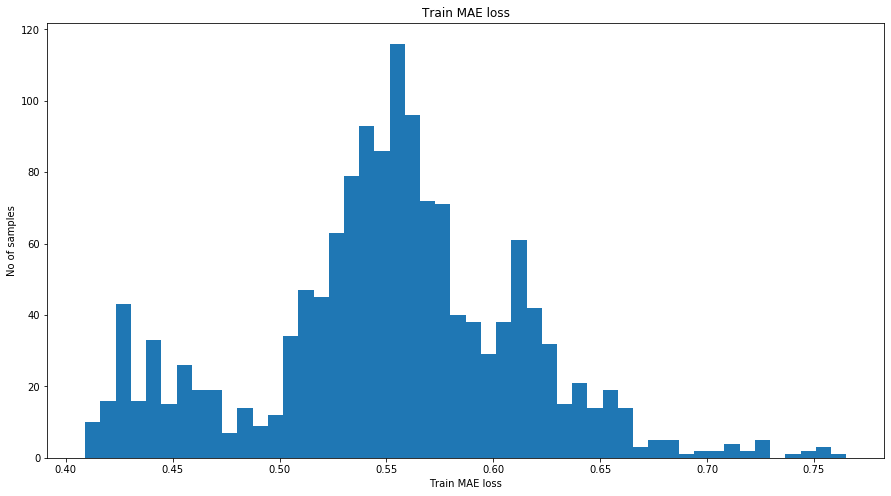

Reconstruction error threshold:  0.7650418352712473


In [325]:
threshold, trainXpred, train_mae_loss = plot_loss_acc(history, model, 1,5)

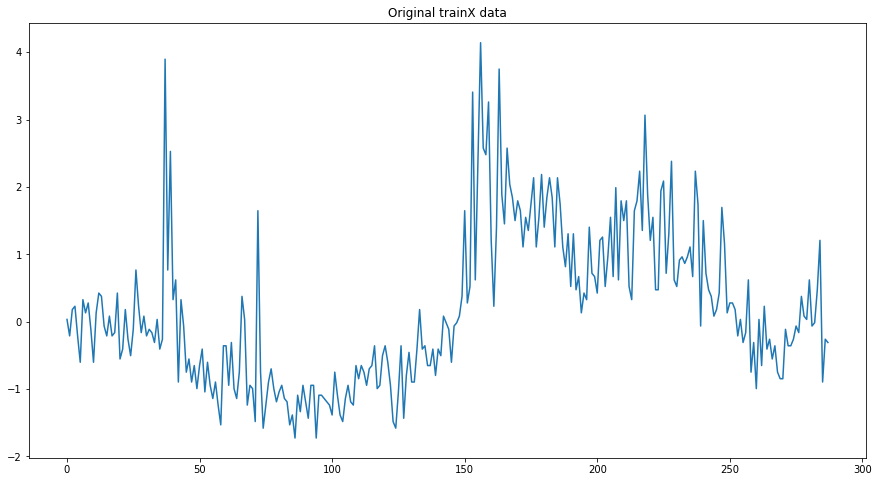

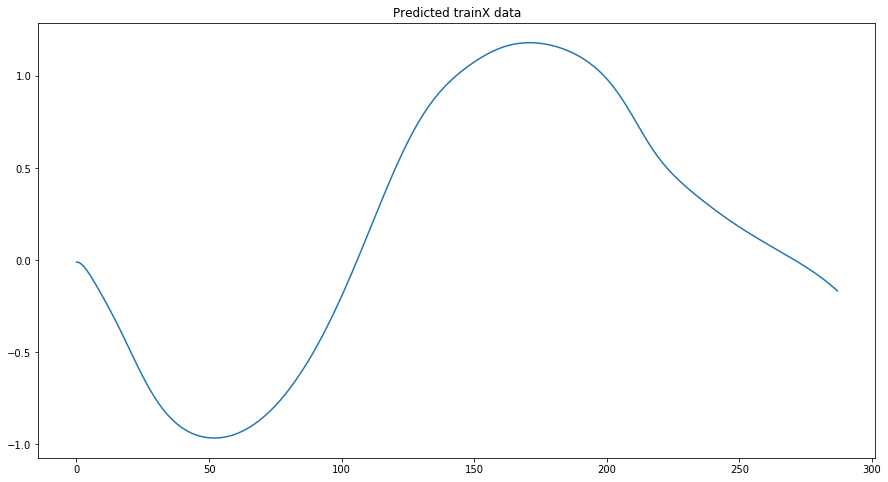

In [326]:
plot_train_pred(trainX, trainXpred)

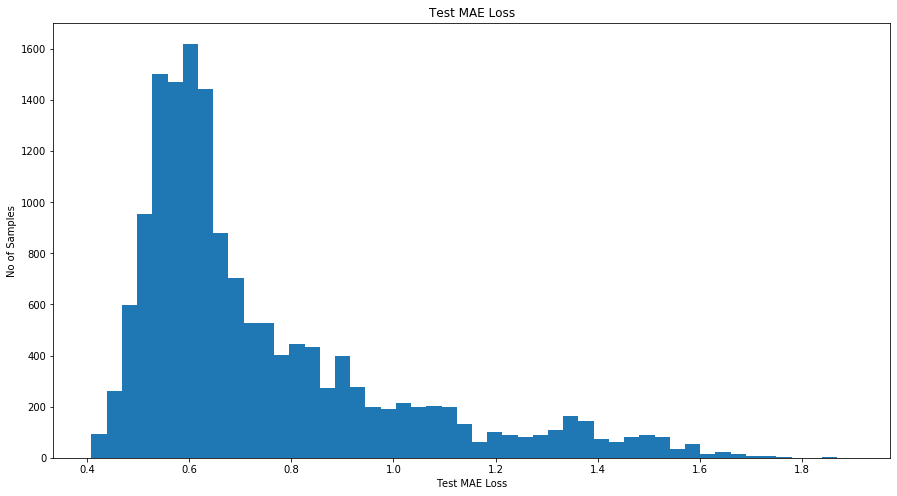

Number of anomaly samples:  4976
Indices of anomaly samples:  (array([   58,    59,    60, ..., 15454, 15458, 15459], dtype=int64),)


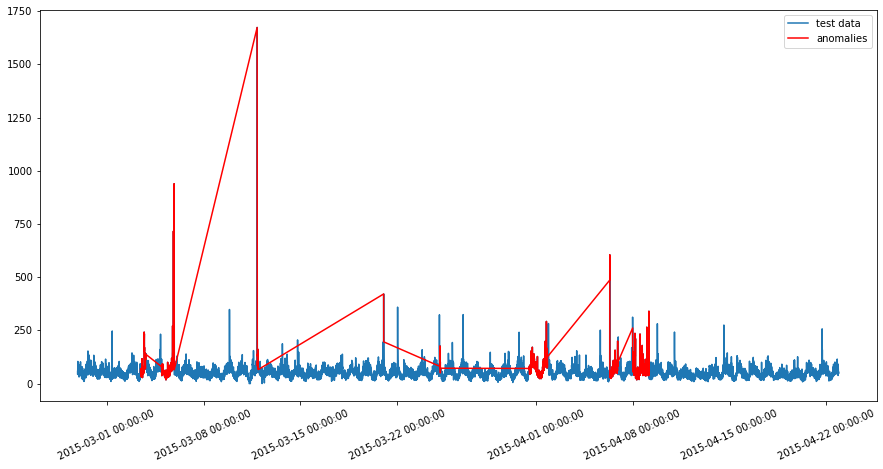

In [327]:
testpred(model, testX, threshold)

# Model 2

#### LSTM Autoencoder

In [328]:
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed

model = keras.Sequential()
#ENCODER
model.add(keras.layers.LSTM(units=64,input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(keras.layers.Dropout(rate=0.2))
#DECODER
model.add(keras.layers.RepeatVector(n=trainX.shape[1]))
model.add(keras.layers.LSTM(units=64, return_sequences=True))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=trainX.shape[2])))

model.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=0.001))
model.summary()

Model: "sequential_48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_67 (LSTM)               (None, 64)                16896     
_________________________________________________________________
dropout_94 (Dropout)         (None, 64)                0         
_________________________________________________________________
repeat_vector_22 (RepeatVect (None, 288, 64)           0         
_________________________________________________________________
lstm_68 (LSTM)               (None, 288, 64)           33024     
_________________________________________________________________
dropout_95 (Dropout)         (None, 288, 64)           0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 288, 1)            65        
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________

In [329]:
history = fit_model(sequence_autoencoder)

Epoch 1/100
11/11 [==============================] - 3s 261ms/step - loss: 0.9223 - val_loss: 0.9382
Epoch 2/100
11/11 [==============================] - 2s 225ms/step - loss: 0.9225 - val_loss: 0.9388
Epoch 3/100
11/11 [==============================] - 2s 217ms/step - loss: 0.9226 - val_loss: 0.9353
Epoch 4/100
11/11 [==============================] - 2s 218ms/step - loss: 0.9227 - val_loss: 0.9355
Epoch 5/100
11/11 [==============================] - 2s 218ms/step - loss: 0.9226 - val_loss: 0.9384
Epoch 6/100
11/11 [==============================] - 2s 215ms/step - loss: 0.9223 - val_loss: 0.9409
Epoch 7/100
11/11 [==============================] - 2s 220ms/step - loss: 0.9223 - val_loss: 0.9377
Epoch 8/100
11/11 [==============================] - 2s 216ms/step - loss: 0.9225 - val_loss: 0.9382


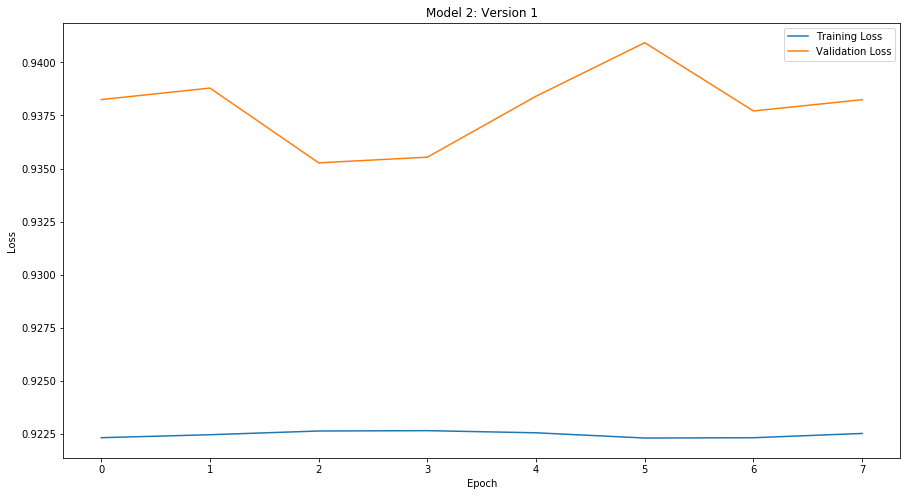

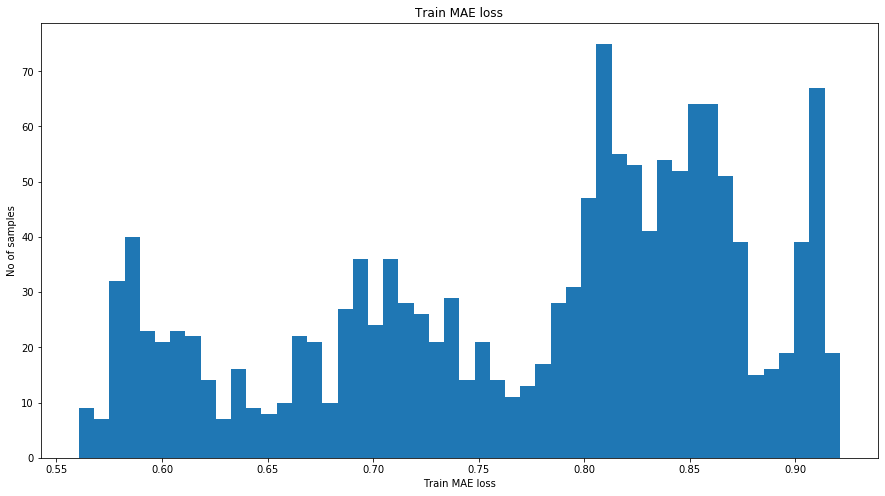

Reconstruction error threshold:  0.9210322851577293


In [330]:
threshold, trainXpred, train_mae_loss = plot_loss_acc(history, model, 2, 1)

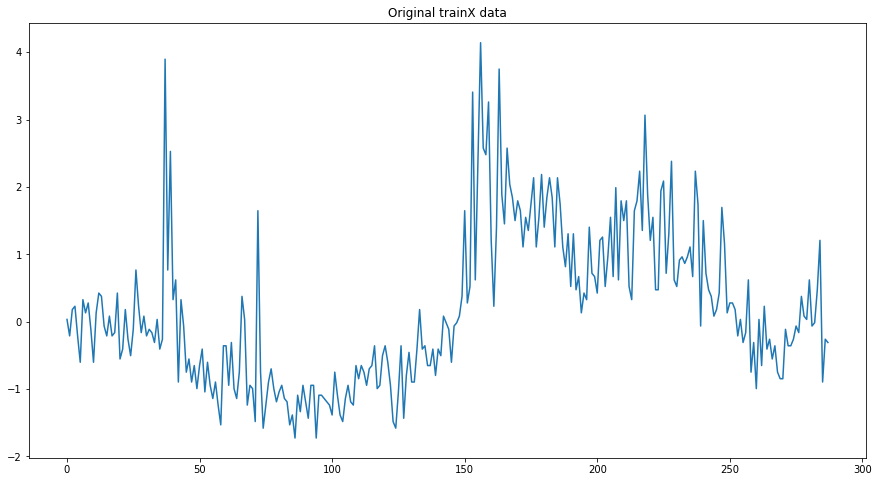

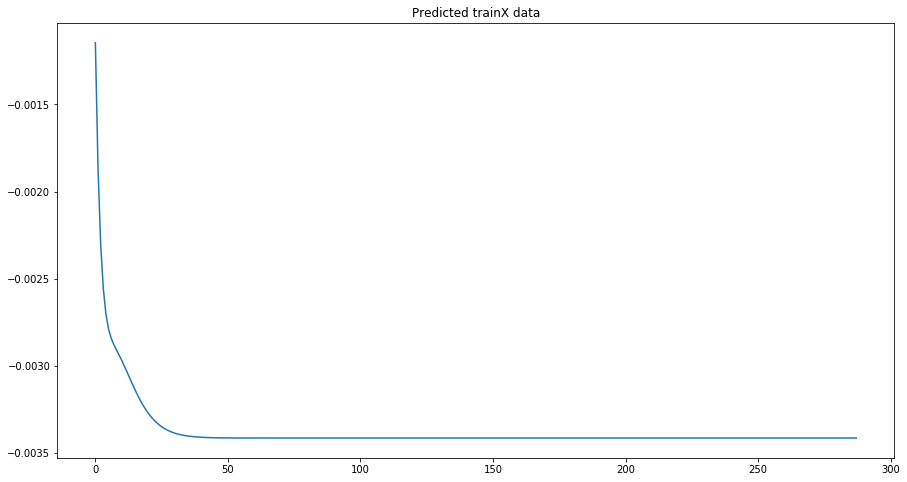

In [331]:
plot_train_pred(trainX, trainXpred)

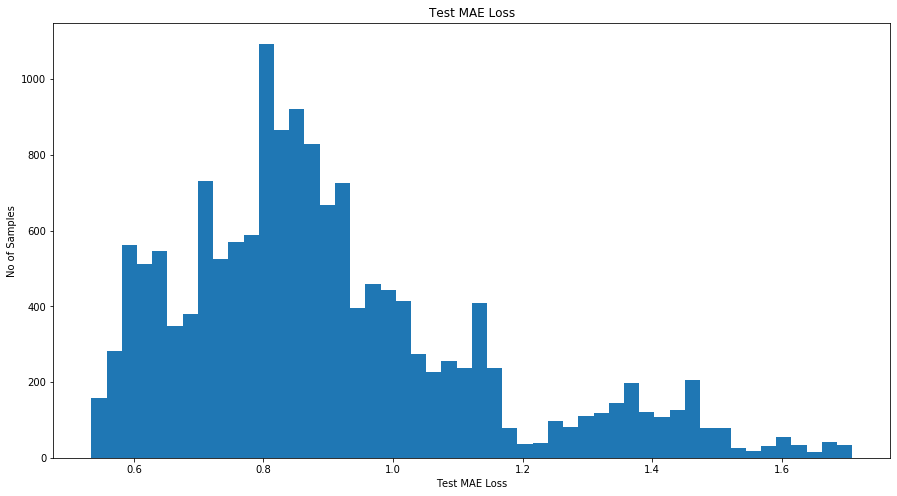

Number of anomaly samples:  5564
Indices of anomaly samples:  (array([  122,   123,   124, ..., 15488, 15489, 15490], dtype=int64),)


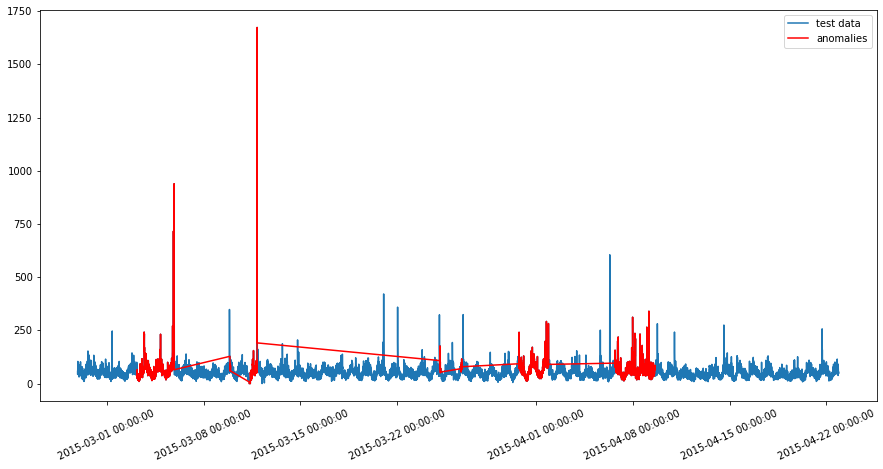

In [332]:
testpred(model, testX, threshold)

# Model 3

#### Deep convolutional autoencoder

In [333]:
model = keras.Sequential(
    [   
        ##ENCODER
        layers.Input(shape=(trainX.shape[1], trainX.shape[2])),
        layers.Conv1D(
            filters=32, kernel_size=4, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16, kernel_size=4, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=8, kernel_size=4, padding="same", strides=2, activation="relu"
        ),
        
        ### DECODER
        layers.Conv1DTranspose(
            filters=8, kernel_size=4, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=16, kernel_size=4, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32, kernel_size=4, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=4, padding="same")
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_71 (Conv1D)           (None, 144, 32)           160       
_________________________________________________________________
dropout_96 (Dropout)         (None, 144, 32)           0         
_________________________________________________________________
conv1d_72 (Conv1D)           (None, 72, 16)            2064      
_________________________________________________________________
dropout_97 (Dropout)         (None, 72, 16)            0         
_________________________________________________________________
conv1d_73 (Conv1D)           (None, 36, 8)             520       
_________________________________________________________________
conv1d_transpose_115 (Conv1D (None, 72, 8)             264       
_________________________________________________________________
dropout_98 (Dropout)         (None, 72, 8)           

In [334]:
history = fit_model(model)

Epoch 1/100
11/11 [==============================] - 2s 144ms/step - loss: 0.9471 - val_loss: 0.8576
Epoch 2/100
11/11 [==============================] - 1s 98ms/step - loss: 0.7945 - val_loss: 0.6233
Epoch 3/100
11/11 [==============================] - 1s 106ms/step - loss: 0.5970 - val_loss: 0.5478
Epoch 4/100
11/11 [==============================] - 1s 96ms/step - loss: 0.5368 - val_loss: 0.4862
Epoch 5/100
11/11 [==============================] - 1s 95ms/step - loss: 0.4859 - val_loss: 0.4574
Epoch 6/100
11/11 [==============================] - 1s 88ms/step - loss: 0.4419 - val_loss: 0.4091
Epoch 7/100
11/11 [==============================] - 1s 89ms/step - loss: 0.4053 - val_loss: 0.3778
Epoch 8/100
11/11 [==============================] - 1s 89ms/step - loss: 0.3740 - val_loss: 0.3587
Epoch 9/100
11/11 [==============================] - 1s 89ms/step - loss: 0.3567 - val_loss: 0.3447
Epoch 10/100
11/11 [==============================] - 1s 86ms/step - loss: 0.3442 - val_loss: 0.33

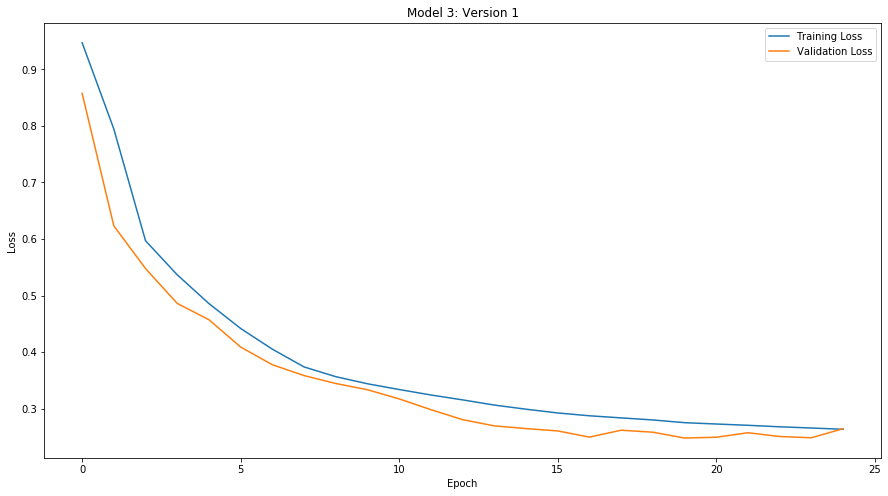

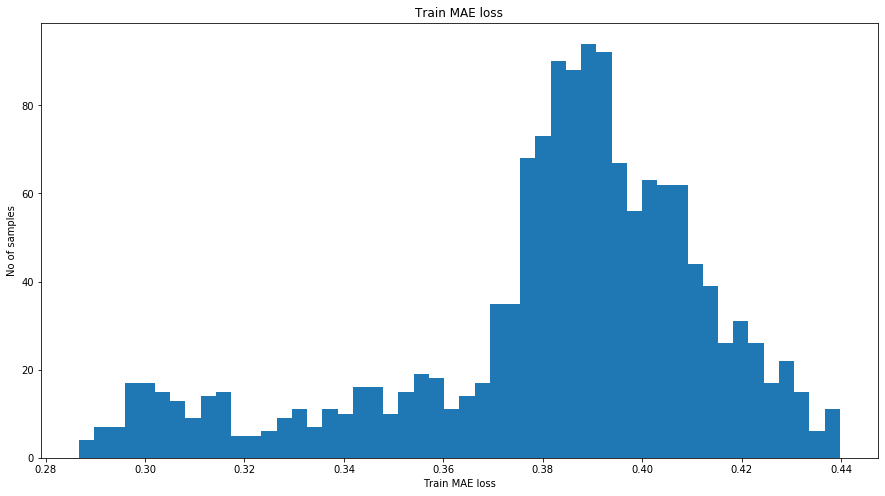

Reconstruction error threshold:  0.43969696053440266


In [335]:
threshold, trainXpred, train_mae_loss = plot_loss_acc(history, model, 3, 1)

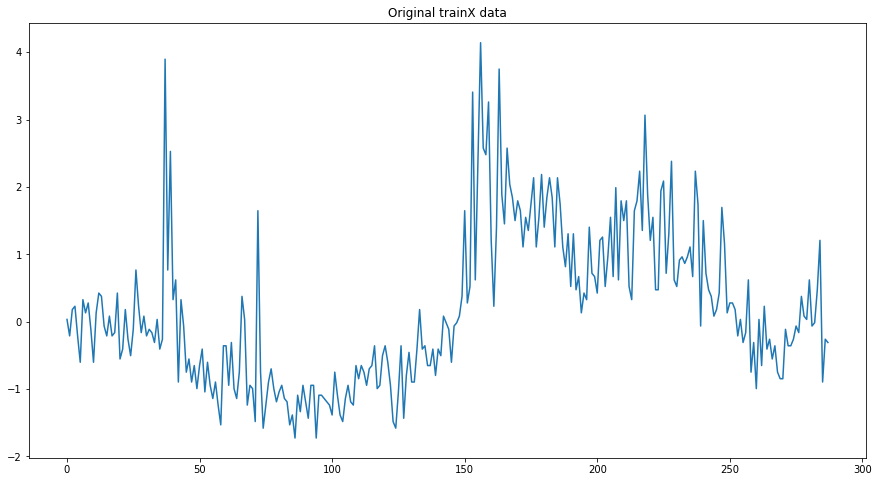

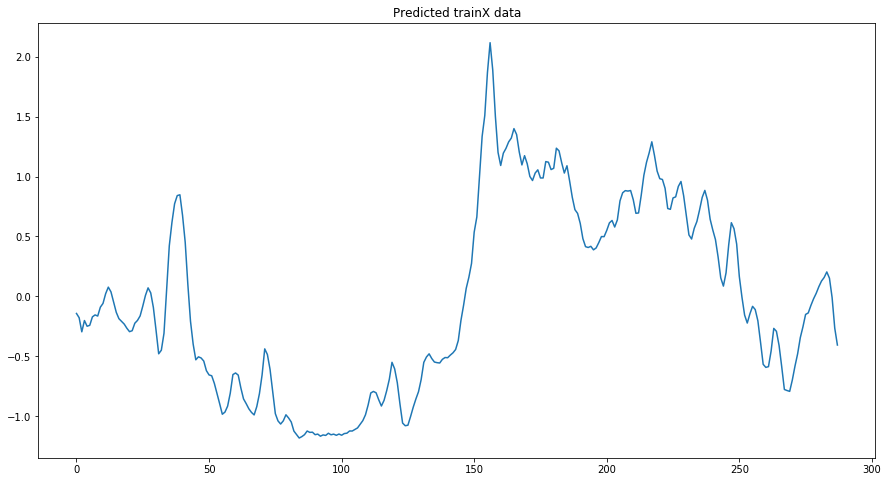

In [336]:
plot_train_pred(trainX, trainXpred)

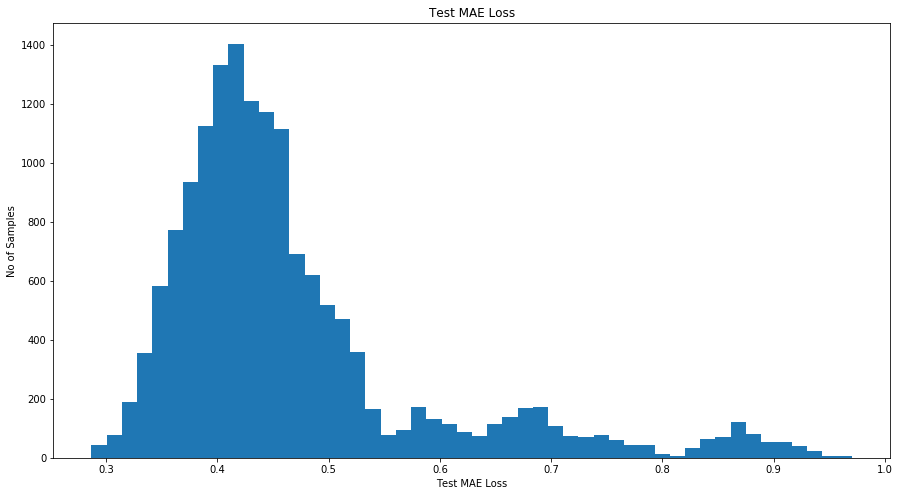

Number of anomaly samples:  7305
Indices of anomaly samples:  (array([    0,     1,     2, ..., 15526, 15527, 15538], dtype=int64),)


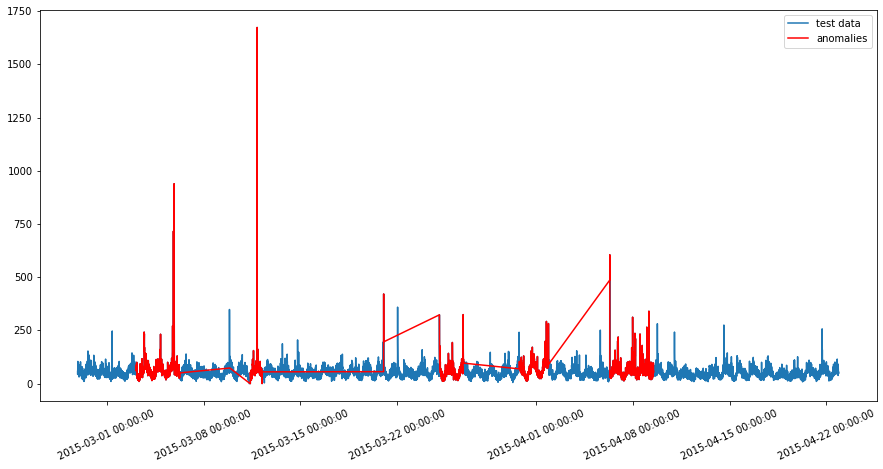

In [337]:
testpred(model, testX, threshold)

### References

##### https://towardsdatascience.com/extreme-rare-event-classification-using-autoencoders-in-keras-a565b386f098
##### https://towardsdatascience.com/autoencoders-for-the-compression-of-stock-market-data-28e8c1a2da3e
##### https://www.curiousily.com/posts/anomaly-detection-in-time-series-with-lstms-using-keras-in-python/
##### https://keras.io/examples/timeseries/timeseries_anomaly_detection/
##### https://machinelearningmastery.com/lstm-autoencoders/

### Observations
#### All 3 of the models perform quite well and similarly to each other. However, model 1 and 3 seem to catch a few more anomalies in our dataset than model 2. To truly determine which model performed the best we would need to know the true labels of which data points are considered anamolies. If the 3 very far out data points are the only outliers then model 2 performs the best. However, if the smaller spikes are also included, model 1 and model 3 seem to perform better.